# OR Tools for Vehicle Routing Problem (VRP)
- 在 VRP 中，目標是找出多組前往某地點的最佳路線 (最短距離)
- 如果沒有其他限制，最佳解決方案就是指派一個可造訪所有位置的車輛，會降低為 TSP 問題
- 距離單位為 Meters

In [5]:
import random as rd
import numpy as np
import pandas as pd
import math

import time
import datetime

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

import matplotlib.pyplot as plt
import seaborn as sns

### 1. 定義參數

In [6]:
NUM_NODES = 16

MAX_X = 20
MAX_Y = 20

NUM_VEHICLES = 4
NUM_DEPOT = 0

### 2. 建立資料

In [7]:
# 建立資料集
def create_data_model():

    data = {}
    data["num_locations"] = [(rd.randint(1, MAX_X), rd.randint(1, MAX_Y)) for i in range(NUM_NODES)] # 亂數產生 node 座標
    data["num_locations"][0] = (int(MAX_X / 2), int(MAX_Y / 2)) # 假設車輛皆從第中心點 index=0 的 node 出發
    data["distance_matrix"] = compute_manhattan_distance_matrix(data["num_locations"])
    data["num_vehicles"] = NUM_VEHICLES
    data["depot"] = NUM_DEPOT
    return data

def compute_manhattan_distance_matrix(nodes):
    distance_matrix = []
    for node_i in nodes:
        distances = []
        for node_j in nodes:
            if node_i == node_j:
                distances.append(0)
            else:
                manhattan_distance = np.sum(np.abs(np.array(node_i) - np.array(node_j)))
                distances.append(manhattan_distance)
        distance_matrix.append(distances)
    return distance_matrix

def create_result_model():
    result = {}
    result["routes"] = []
    return result

data = create_data_model()
result = create_result_model()
pd.DataFrame(data).head(5)

,num_locations,distance_matrix,num_vehicles,depot
0,"(10, 10)","[0, 12, 12, 20, 9, 14, 14, 11, 13, 10, 4, 16, ...",4,0
1,"(20, 8)","[12, 0, 0, 12, 13, 26, 12, 11, 25, 22, 16, 14,...",4,0
2,"(20, 8)","[12, 0, 0, 12, 13, 26, 12, 11, 25, 22, 16, 14,...",4,0
3,"(20, 20)","[20, 12, 12, 0, 11, 22, 24, 23, 25, 20, 18, 4,...",4,0
4,"(14, 15)","[9, 13, 13, 11, 0, 13, 15, 12, 14, 9, 7, 7, 4,...",4,0


### 3. 建立路徑模型

In [8]:
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    max_route_distance = 0
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        plan_output = f"Route for vehicle {vehicle_id}:\n"
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += f" {manager.IndexToNode(index)} -> "
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id
            )
        plan_output += f"{manager.IndexToNode(index)}\n"
        plan_output += f"Distance of the route: {route_distance}m\n"
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    print(f"Maximum of the route distances: {max_route_distance}m")

# Save routes to a list or array
def get_routes(solution, routing, manager):
    """Get vehicle routes from a solution and store them in an array."""
    # Get vehicle routes and store them in a two dimensional array whose
    # i,j entry is the jth location visited by vehicle i along its route.
    routes = []
    for route_nbr in range(routing.vehicles()):
        index = routing.Start(route_nbr)
        route = [manager.IndexToNode(index)]
        while not routing.IsEnd(index):
            index = solution.Value(routing.NextVar(index))
            route.append(manager.IndexToNode(index))
        routes.append(route)
    return routes

def main():
    """Entry point of the program."""
    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(data["distance_matrix"]), data["num_vehicles"], data["depot"]
    )

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint.
    dimension_name = "Distance"
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        3000,  # vehicle maximum travel distance
        True,  # start cumul to zero
        dimension_name,
    )
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # Setting first solution heuristic. 此處可調解題使用的演算法
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    # 第一個解當作最佳解
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )

    # 局部搜尋法 -> Greedy
    # search_parameters.local_search_metaheuristic = (
    #     routing_enums_pb2.LocalSearchMetaheuristic.GREEDY_DESCENT
    # )
    # search_parameters.time_limit.seconds = 10
    # search_parameters.log_search = True

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(data, manager, routing, solution)
        result["routes"] = get_routes(solution, routing, manager)   
    else:
        print("No solution found !")

if __name__ == "__main__":
    main()

Objective: 4132
Route for vehicle 0:
 0 ->  14 ->  8 ->  5 ->  9 ->  10 -> 0
Distance of the route: 30m

Route for vehicle 1:
 0 ->  7 ->  6 ->  15 ->  13 -> 0
Distance of the route: 38m

Route for vehicle 2:
 0 ->  4 ->  12 ->  11 ->  3 -> 0
Distance of the route: 40m

Route for vehicle 3:
 0 ->  2 ->  1 -> 0
Distance of the route: 24m

Maximum of the route distances: 40m


### 4. 繪圖

In [11]:
# 多車輛問題時為了將車輛的路徑分成不同顏色，需要先畫路徑在畫圖
def plot_map():

    sns.set()
    plt.figure(figsize=(7, 7))
    plt.title('Tralveling Salesman Problem (TSP) solved by OR-Tools')
    plt.grid(color='gray', linestyle='-', linewidth=1, alpha=0.2)
    plt.xlim(0, MAX_X)
    plt.ylim(0, MAX_Y)

    # 有產出路徑，繪製路徑 & 不同車輛經過點的顏色
    if len(result["routes"]):
        for route in result["routes"]:
            # Draw lines
            RGB_colors = tuple(round(rd.uniform(0,1), 1) for i in range(3))
            arrow_kwargs = dict(length_includes_head=True, head_width=0.5, head_length=1, color=RGB_colors, alpha=0.8)

            for index, node in enumerate(route):
                start_loc = data['num_locations'][route[index]]
                end_loc = data['num_locations'][route[index + 1]] if index < (len(route) - 1) else data['num_locations'][0]

                plt.arrow(x=start_loc[0], y=start_loc[1], dx=(end_loc[0] - start_loc[0]), dy=(end_loc[1] - start_loc[1]), **arrow_kwargs)

            # Draw nodes
            for i in route:
                text_kwargs = dict(s=str(i), fontsize=10, color="white", horizontalalignment='center', verticalalignment='center')
                node_kwargs = dict(s=500, color='black', alpha=0.7, edgecolors='black')

                if i == 0: 
                    continue
                node_kwargs['color'] = RGB_colors
                node = data['num_locations'][i]
                plt.scatter(x=node[0], y=node[1], **node_kwargs)
                plt.text(x=node[0], y=node[1], **text_kwargs)
            
            # Draw start node. 由於圖片會覆蓋掉, 故起始點最後才畫
            start_node = data['num_locations'][0]
            plt.scatter(x=start_node[0], y=start_node[1], s=500, color='black', alpha=0.7, edgecolors='black') 
            plt.text(x=start_node[0], y=start_node[1], s='0', fontsize=10, color="white", horizontalalignment='center', verticalalignment='center')

    # 沒路徑，只畫 node
    else:    
        if len(data['num_locations']) > 0:
            
            for index, node in enumerate(data['num_locations']):
                node_kwargs = dict(s=500, color='gray', alpha=0.7, edgecolors='black')
                text_kwargs = dict(s=str(index), fontsize=10, color="white", horizontalalignment='center', verticalalignment='center')
                if index == 0: 
                    plt.scatter(x=node[0], y=node[1], s=500, color='black', alpha=0.7, edgecolors='black') 
                    plt.text(x=node[0], y=node[1], s='0', fontsize=10, color="white", horizontalalignment='center', verticalalignment='center')
                    continue
                plt.scatter(x=node[0], y=node[1], **node_kwargs)
                plt.text(x=node[0], y=node[1], **text_kwargs)

        else:
            print("No data to plot.")

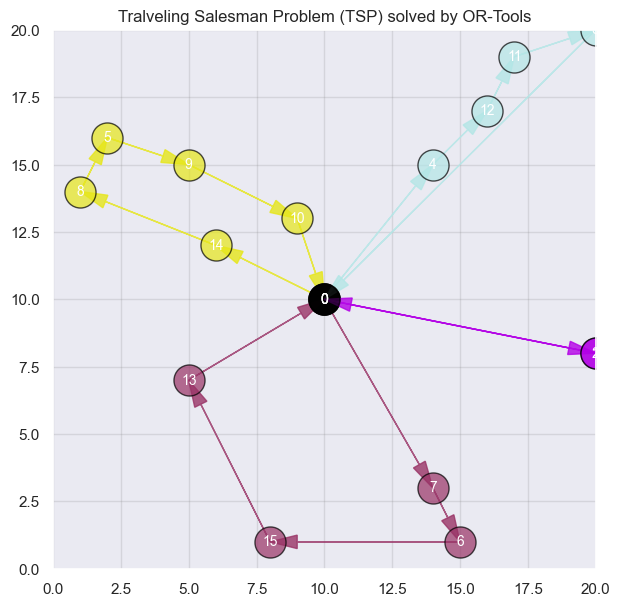

In [12]:
plot_map()

#### 如果問題沒有解決方式，該怎麼辦？
設有限制的轉送問題 (例如 CVRP) 可能沒有可行的解決方案，例如，如果傳輸的項目總數超過車輛的總數。當您嘗試解決這類問題時，解題工具可能會執行詳盡的搜尋，且最終必須等待較長的時間，才能放棄並中斷程式。

這通常不是問題。但下列幾種方法可以防止您的程式在問題未解決時執行很長的時間：

- 為程式設定「時間限制」。即使沒有找到任何解決方案，系統也會停止搜尋。不過請注意，如果解決方案需要執行時間較長的搜尋，程式可能會在達到解決方案前達到時間限制。
- 設定**停靠點**以降低造訪地點的次數。如此就能讓解題工具傳回不解所有位置的「解決方案」，以解決無法解決的問題。請參閱「懲罰與掉落的來訪」一文。

一般來說，我們很難判別某個問題有解決方法。即使 ZRP 的總需求量不會超過總容量，仍可以判斷所有項目是否適用於車輛，是多重刀擊模式問題。

## VRP 原始程式碼

In [10]:
def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data["num_locations"] = [
        (456, 320), # location 0 - the depot
        (228, 0),    # location 1
        (912, 0),    # location 2
        (0, 80),     # location 3
        (114, 80),   # location 4
        (570, 160),  # location 5
        (798, 160),  # location 6
        (342, 240),  # location 7
        (684, 240),  # location 8
        (570, 400),  # location 9
        (912, 400),  # location 10
        (114, 480),  # location 11
        (228, 480),  # location 12
        (342, 560),  # location 13
        (684, 560),  # location 14
        (0, 640),    # location 15
        (798, 640)   # location 16
    ]  

    data["distance_matrix"] = [
        # fmt: off
        [0, 548, 776, 696, 582, 274, 502, 194, 308, 194, 536, 502, 388, 354, 468, 776, 662],
        [548, 0, 684, 308, 194, 502, 730, 354, 696, 742, 1084, 594, 480, 674, 1016, 868, 1210],
        [776, 684, 0, 992, 878, 502, 274, 810, 468, 742, 400, 1278, 1164, 1130, 788, 1552, 754],
        [696, 308, 992, 0, 114, 650, 878, 502, 844, 890, 1232, 514, 628, 822, 1164, 560, 1358],
        [582, 194, 878, 114, 0, 536, 764, 388, 730, 776, 1118, 400, 514, 708, 1050, 674, 1244],
        [274, 502, 502, 650, 536, 0, 228, 308, 194, 240, 582, 776, 662, 628, 514, 1050, 708],
        [502, 730, 274, 878, 764, 228, 0, 536, 194, 468, 354, 1004, 890, 856, 514, 1278, 480],
        [194, 354, 810, 502, 388, 308, 536, 0, 342, 388, 730, 468, 354, 320, 662, 742, 856],
        [308, 696, 468, 844, 730, 194, 194, 342, 0, 274, 388, 810, 696, 662, 320, 1084, 514],
        [194, 742, 742, 890, 776, 240, 468, 388, 274, 0, 342, 536, 422, 388, 274, 810, 468],
        [536, 1084, 400, 1232, 1118, 582, 354, 730, 388, 342, 0, 878, 764, 730, 388, 1152, 354],
        [502, 594, 1278, 514, 400, 776, 1004, 468, 810, 536, 878, 0, 114, 308, 650, 274, 844],
        [388, 480, 1164, 628, 514, 662, 890, 354, 696, 422, 764, 114, 0, 194, 536, 388, 730],
        [354, 674, 1130, 822, 708, 628, 856, 320, 662, 388, 730, 308, 194, 0, 342, 422, 536],
        [468, 1016, 788, 1164, 1050, 514, 514, 662, 320, 274, 388, 650, 536, 342, 0, 764, 194],
        [776, 868, 1552, 560, 674, 1050, 1278, 742, 1084, 810, 1152, 274, 388, 422, 764, 0, 798],
        [662, 1210, 754, 1358, 1244, 708, 480, 856, 514, 468, 354, 844, 730, 536, 194, 798, 0],
        # fmt: on
    ]
    data["num_vehicles"] = 4
    data["depot"] = 0
    return data

def print_solution(data, manager, routing, solution):
    
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    max_route_distance = 0
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        plan_output = f"Route for vehicle {vehicle_id}:\n"
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += f" {manager.IndexToNode(index)} -> "
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id
            )
        plan_output += f"{manager.IndexToNode(index)}\n"
        plan_output += f"Distance of the route: {route_distance}m\n"
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    print(f"Maximum of the route distances: {max_route_distance}m")

# Save routes to a list or array
def get_routes(solution, routing, manager):
    """Get vehicle routes from a solution and store them in an array."""
    # Get vehicle routes and store them in a two dimensional array whose
    # i,j entry is the jth location visited by vehicle i along its route.
    routes = []
    for route_nbr in range(routing.vehicles()):
        index = routing.Start(route_nbr)
        route = [manager.IndexToNode(index)]
        while not routing.IsEnd(index):
            index = solution.Value(routing.NextVar(index))
            route.append(manager.IndexToNode(index))
        routes.append(route)
    return routes

def main():
    """Entry point of the program."""
    # Instantiate the data problem.
    data = create_data_model()
    # data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(data["distance_matrix"]), data["num_vehicles"], data["depot"]
    )

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint.
    dimension_name = "Distance"
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        3000,  # vehicle maximum travel distance
        True,  # start cumul to zero
        dimension_name,
    )
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(data, manager, routing, solution)
        return get_routes(solution, routing, manager) 
    else:
        print("No solution found !")

if __name__ == "__main__":
    routes = main()

Objective: 177500
Route for vehicle 0:
 0 ->  9 ->  10 ->  2 ->  6 ->  5 -> 0
Distance of the route: 1712m

Route for vehicle 1:
 0 ->  16 ->  14 ->  8 -> 0
Distance of the route: 1484m

Route for vehicle 2:
 0 ->  7 ->  1 ->  4 ->  3 -> 0
Distance of the route: 1552m

Route for vehicle 3:
 0 ->  13 ->  15 ->  11 ->  12 -> 0
Distance of the route: 1552m

Maximum of the route distances: 1712m


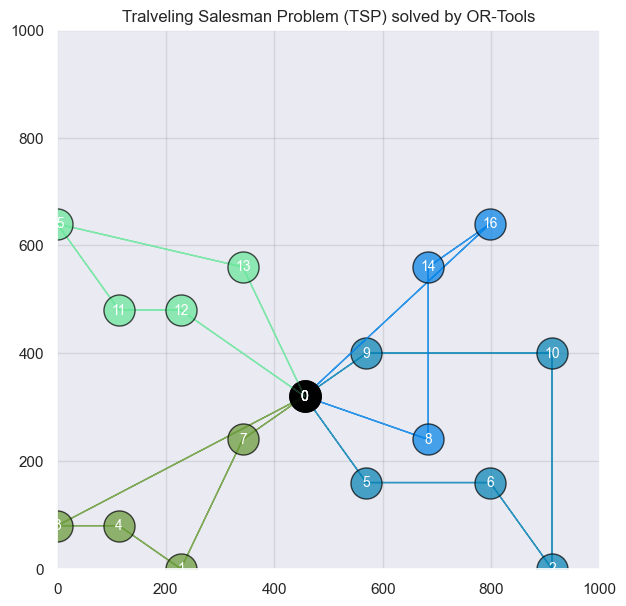

In [11]:
def create_result_model():
    result = {}
    result["routes"] = routes

    return result

data = create_data_model()
result = create_result_model()

plot_map()